# Proyecto Detección de Cáncer Cerebral para diagnóstico médico.

## Acerca del conjunto de datos

### Cáncer cerebral
Conjunto de datos de resonancia magnética

Este conjunto de datos contiene una colección completa de imágenes de resonancia magnética para la investigación del cáncer cerebral, específicamente destinadas a respaldar el diagnóstico médico.

## Categorías
- Educación médica
- Cáncer cerebral
- Aprendizaje automático
- Clasificación de imágenes
- Áreas del cerebro
- Aprendizaje profundo

### Inicio del proyecto
Previamente ha sido ejecutado un script para la separación adecuada del conjunto de imágenes en entrenamiento, test y validación.

- 70% Entrenamiento
- 15% Test
- 15% Validación

### Comprobar que usamos GPU

In [1]:
import torch
print(torch.cuda.is_available())      # → True si está OK
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce MX150


# Módulos

In [15]:
from torchvision import transforms # Transforma el dataset

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import torch.nn as nn # Arquitectura de Red
import torch.nn.functional as F

import torch
from torch import optim

from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt

# Transformación

In [11]:
transformaciones_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformaciones_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carga del Set de Datos

In [12]:
train_dataset = ImageFolder('data/train', transform=transformaciones_train)
val_dataset   = ImageFolder('data/val', transform=transformaciones_test)
test_dataset  = ImageFolder('data/test', transform=transformaciones_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

# Definir Arquitectura

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 3) # ¡CORREGIDO! 3 clases según tu set de datos

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x 

# Entrenamiento y Validación

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # FASE DE VALIDACIÓN (CORREGIDO)
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy Validación: {val_accuracy:.2f}%')
    
    # Llama al scheduler al final de la época
    scheduler.step()


Epoch [1/25], Loss: 1.0685, Accuracy Validación: 59.54%
Epoch [2/25], Loss: 0.8930, Accuracy Validación: 65.27%
Epoch [3/25], Loss: 0.8210, Accuracy Validación: 74.64%
Epoch [4/25], Loss: 0.7496, Accuracy Validación: 77.73%
Epoch [5/25], Loss: 0.6877, Accuracy Validación: 75.08%
Epoch [6/25], Loss: 0.6378, Accuracy Validación: 81.48%
Epoch [7/25], Loss: 0.5746, Accuracy Validación: 84.23%
Epoch [8/25], Loss: 0.4928, Accuracy Validación: 88.53%
Epoch [9/25], Loss: 0.4882, Accuracy Validación: 88.64%
Epoch [10/25], Loss: 0.4549, Accuracy Validación: 88.53%
Epoch [11/25], Loss: 0.4393, Accuracy Validación: 89.97%
Epoch [12/25], Loss: 0.4454, Accuracy Validación: 89.97%
Epoch [13/25], Loss: 0.4319, Accuracy Validación: 89.97%
Epoch [14/25], Loss: 0.4285, Accuracy Validación: 87.21%
Epoch [15/25], Loss: 0.4126, Accuracy Validación: 91.18%
Epoch [16/25], Loss: 0.4224, Accuracy Validación: 90.74%
Epoch [17/25], Loss: 0.3957, Accuracy Validación: 90.19%
Epoch [18/25], Loss: 0.4049, Accuracy Va

# Evaluar con conjunto de validación

Predicción: 0, Real: 2


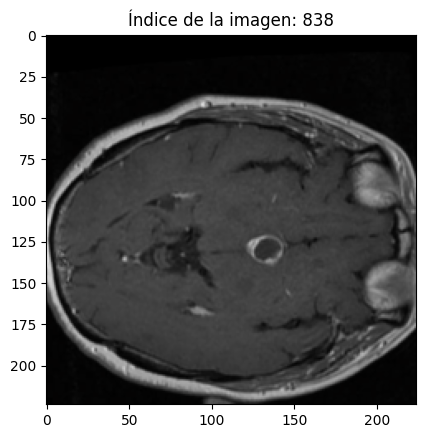

In [18]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

imagen_a_predecir_idx = 838  # Puedes cambiar este número 912 imágenes en total, por lo que el índice válido va de 0 a 911

# Verificar si el índice está dentro del rango
if imagen_a_predecir_idx >= len(test_dataset):
    print(f"Error: El índice {imagen_a_predecir_idx} está fuera del rango del conjunto de test, que tiene {len(test_dataset)} imágenes.")
else:
    # Obtener la imagen y la etiqueta
    img_tuple = test_dataset[imagen_a_predecir_idx]
    img = img_tuple[0]
    label = img_tuple[1]

    # Mover la imagen a la GPU y añadir una dimensión de lote
    img = img.to(device)
    img_with_batch = img.unsqueeze(0)

    # Poner el modelo en modo de evaluación
    model.eval()

    # Realizar la predicción
    with torch.no_grad():
        output = model(img_with_batch)
        _, pred = torch.max(output, 1)

    print(f"Predicción: {pred.item()}, Real: {label}")

    # Desnormalizar la imagen para su visualización
    img_desnormalizada = img.cpu() * std.view(3, 1, 1) + mean.view(3, 1, 1)
    
    # Recortar los valores para asegurar que estén en [0, 1]
    img_desnormalizada = torch.clamp(img_desnormalizada, 0, 1)

    # Mostrar la imagen
    plt.imshow(img_desnormalizada.permute(1, 2, 0))
    plt.title(f"Índice de la imagen: {imagen_a_predecir_idx}")
    plt.show()

# Accuracy final con datos de Test

In [55]:
import torch

# Asegúrate de que el modelo ya está entrenado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Poner el modelo en modo de evaluación
model.eval()

correct = 0
total = 0

# Desactivar el cálculo de gradientes
with torch.no_grad():
    # Iterar sobre el DataLoader del conjunto de test
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Realizar la predicción
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'Precisión del modelo en las {total} imágenes de test: {final_accuracy:.2f}%')

Precisión del modelo en las 912 imágenes de test: 91.23%


# Guardar Modelo

In [56]:
model_name = "torch_brain_cancer"
torch.save(model.state_dict(), model_name)

### Cargar el modelo (only weights)

In [8]:
model = SimpleCNN()
model.load_state_dict(torch.load('modelo/torch_brain_cancer_91', weights_only=True)) # Cargar presos del modelo 

<All keys matched successfully>

# Conclusión Modelo
### ¿Qué predice el modelo?
El modelo no predice simplemente "cáncer" o "no cáncer" con una respuesta binaria. En su lugar, es un clasificador multiclase que predice a cuál de las 4 clases mencionadas anteriormente pertenece una imagen.

- Si predice la Clase 0, significa que ha identificado un tumor de tipo glioma.

- Si predice la Clase 1, significa que ha identificado un tumor de tipo meningioma.

- Si predice la Clase 2, significa que la imagen no tiene un tumor (no_tumor).

- Si predice la Clase 3, significa que ha identificado un tumor de tipo pituitary.